<a href="https://colab.research.google.com/github/Warvito/Autoregressive-models/blob/master/1%20-%20Autoregressive%20Models%20-%20PixelCNN/pixelCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoregressive Models - PixelCNN

The autoregressive models are generative models that provides an explicit parametric specification of a likelihood function of a variable by specifying it with its parameters. However, to model data that have several dimensions/features, autoregressive models need to define some constraints. First, the observation space X need to have a determining ordering for its features. That is why autoregressive models are naturally used for time series that have a sequence of time steps. However, it can also be employed for images by defining, for example, that the pixels from left come before from the ones in the right, and the ones in the top before the ones in the bottom. Second, to tractably model the joint distribution of the features in a data observation (p(x)), the autoregressive approach cast p(x) as a product of conditional distributions. Autoregressive models define the joint distribution using conditionals over each feature given the values of the previous features. For example, the probability of a pixel from an image to have a specific value is conditioned by the values of all previous pixels; and the probability of an image (the joint distribution) is the combination of the probability of all its pixels. This way, autoregressive models use the chain rule to decompose the likelihood of the data sample x into a product of 1-dimensional distributions (Eq. 1). The factorization turns the joint modelling problem into a sequence problem, where one learns to predict the next pixel given all the previously generated pixels.

<img src="figures/Figure3.png" width="250">

This is what mainly define an autoregressive model.

Now, the big challenge is how to represent these conditional this p(xi) that usually has a really complex distribution. How could we define it in an expressive model that are also tractable and scalable? One solution is using deep neural networks. 


## PixelCNN
PixelCNN was introduced by DeepMind in 2016 (Oord et al, 2016) and it started one of the most promising families of autoregressive generative models. PixelCNN is a deep neural network that captures the distribution of dependencies between pixels in the parameters. It sequentially generates one pixel at a time in an image along the two spatial dimensions. 



In this implementation, we used the new Tensorflow 2.0 framework. In the fisrt step we install and import the code dependencies.

In [1]:
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


In [2]:
import random as rn
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Progbar

Then, we define the random seeds to have reproducible results and we load the MNIST dataset to train the PixelCNN.

In [3]:
# Defining random seeds
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
rn.seed(random_seed)

In [4]:
# Loading data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

height = 28
width = 28
n_channel = 1

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape(x_train.shape[0], height, width, n_channel)
x_test = x_test.reshape(x_test.shape[0], height, width, n_channel)

In this example, to make the probability distribution of a single pixel easier to be defined, we decide to quantisise the number of possible values that a pixel could have. Originally, in the MNIST dataset the pixel are represented bya  a uint8 variable, beeing able assume values between [0, 255]. In this example, we restring the image to have only 4 different values ([0, 3]).

In [5]:
def quantise(images, q_levels):
    """Quantise image into q levels"""
    return (np.digitize(images, np.arange(q_levels) / q_levels) - 1).astype('float32')

In [6]:
# Quantise the input data in q levels
q_levels = 4
x_train_quantised = quantise(x_train, q_levels)
x_test_quantised = quantise(x_test, q_levels)

Using the tensorflow.Data API, we defined the input data streams for our model during the training and the evaluation. In these dataset, we define the inputs as the images with the 4 levels normaized to be between [0, 1] and the target values are the categoricals pixels values between [0, 3].

In [7]:
# Creating input stream using tf.data API
batch_size = 128
train_buf = 60000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_quantised / (q_levels - 1),
                                                    x_train_quantised.astype('int32')))
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_quantised / (q_levels - 1),
                                                   x_test_quantised.astype('int32')))
test_dataset = test_dataset.batch(batch_size)

## Masked Convolutions

When using the convolution operations, PixelCNN can parallelly learn the distribution of all pixels in the image. However, the receptive field of a standard convolutional violates the sequential prediction of autoregressive models. When processing the data of a central pixel, the convolutional filter considers all the pixels around it to calculate the output feature map, not only the previous pixels. 

To solve this problem, masks are adopted block information flow from the future pixels.

Masking can be done by zeroing out all the pixels that should not be considered. In our implementation, a mask with the same size to the convolutional filter with values 1 and 0 was created. This mask was multiplied with the weight tensor before doing the convolution operation.

In the pixelCNN, there are two types of masks: type A and type B.

*	Mask A: this mask is applied only to the first convolutional layer. It restricts to access to the pixel of interest by zeroing the center pixel in mask. This way, we guarantee model will not access the pixel that it is about to predict. 

*	Mask B: This mask is applied to all the subsequent convolutional layers and relaxes the restrictions of mask A by allowing the connection from a pixel to itself. 

Below, we have the masks defined inside a keras layer named MasekdConv2D. In this layer, besides the parameters weigths and bias, we have the constant mask defininng the pixels to be zeroed and the type of mask (A or B) (Lines 41 to 47).

Finally, the mask is applied before the convolution (Line 50).


In [8]:
class MaskedConv2D(tf.keras.layers.Layer):
    """Convolutional layers with masks for autoregressive models

    Convolutional layers with simple implementation to have masks type A and B.
    """

    def __init__(self,
                 mask_type,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros'):
        super(MaskedConv2D, self).__init__()

        assert mask_type in {'A', 'B'}
        self.mask_type = mask_type

        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding.upper()
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel",
                                      shape=(self.kernel_size,
                                             self.kernel_size,
                                             int(input_shape[-1]),
                                             self.filters),
                                      initializer=self.kernel_initializer,
                                      trainable=True)

        self.bias = self.add_weight("bias",
                                    shape=(self.filters,),
                                    initializer=self.bias_initializer,
                                    trainable=True)

        center = self.kernel_size // 2

        mask = np.ones(self.kernel.shape, dtype=np.float32)
        mask[center, center + (self.mask_type == 'B'):, :, :] = 0.
        mask[center + 1:, :, :, :] = 0.

        self.mask = tf.constant(mask, dtype=tf.float32, name='mask')

    def call(self, input):
        masked_kernel = tf.math.multiply(self.mask, self.kernel)
        x = tf.nn.conv2d(input, masked_kernel, strides=[1, self.strides, self.strides, 1], padding=self.padding)
        x = tf.nn.bias_add(x, self.bias)
        return x

## Residual blocks

Another element that compose the PixelCNN architecture is the residual blocks.

In [9]:
class ResidualBlock(tf.keras.Model):
    """Residual blocks that compose pixelCNN

    Blocks of layers with 3 convolutional layers and one residual connection.
    Based on Figure 5 from [1] where h indicates number of filters.

    Refs:
    [1] - Oord, A. V. D., Kalchbrenner, N., & Kavukcuoglu, K. (2016). Pixel
     recurrent neural networks. arXiv preprint arXiv:1601.06759.
    """

    def __init__(self, h):
        super(ResidualBlock, self).__init__(name='')

        self.conv2a = keras.layers.Conv2D(filters=h, kernel_size=1, strides=1)
        self.conv2b = MaskedConv2D(mask_type='B', filters=h, kernel_size=3, strides=1)
        self.conv2c = keras.layers.Conv2D(filters=2 * h, kernel_size=1, strides=1)

    def call(self, input_tensor):
        x = tf.nn.relu(input_tensor)
        x = self.conv2a(x)

        x = tf.nn.relu(x)
        x = self.conv2b(x)

        x = tf.nn.relu(x)
        x = self.conv2c(x)

        x += input_tensor
        return x

## PixelCNN architecture

In Oord et al. 2016, the PixelCNN uses the following architecture (Figure X):

<img src="figures/Figure5_Architecture.png" width="800">

the first layer is a masked convolution (type A) with 7x7 filters. Then, 15 residuals blocks were used. Each block process the data with a combination of 3x3 layers convolutional layers with mask type B and 1x1 standard convolutional layers. Between each convolutional layer there is also a non-linearity ReLU. After these layers, a residual connection is added. Finally, the network has a sequence of RELU-CONV-RELU-CONV using standard convolutional layers, where both have 1x1 filters. Then, the output layer is a softmax layer which predicts the value among all possible values of a pixel. So, this softmax layer had the image dimension (because we want an output value for each pixel) times the number of possible values (for example, 256 pixels values).

In [10]:
# Create PixelCNN model
inputs = keras.layers.Input(shape=(height, width, n_channel))
x = MaskedConv2D(mask_type='A', filters=128, kernel_size=7, strides=1)(inputs)

for i in range(15):
    x = ResidualBlock(h=64)(x)

x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)
x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)
x = keras.layers.Conv2D(filters=n_channel * q_levels, kernel_size=1, strides=1)(x)  # shape [N,H,W,DC]

pixelcnn = tf.keras.Model(inputs=inputs, outputs=x)

In this implementation we use a simple Adam optimizer with learning rate decay to train the neural network. The loss function is defined by the crossentropy (that in this case is equivalent to minimizing the negative log-likelihood of the training data).

In [11]:
# Prepare optimizer and loss function
lr_decay = 0.99995
learning_rate = 1e-2
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

compute_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

The training step is defined by the forward propagation throgh the model, and then the outputs are reshaped to work with several inputs channels (like RGB channels). Finally, the gradients are calculated, clipped to be between [-1, 1], and applied to upgrade the PixelCNN parameters.

In [12]:
@tf.function
def train_step(batch_x, batch_y):
    with tf.GradientTape() as ae_tape:
        logits = pixelcnn(batch_x, training=True)

        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])  # shape [N,H,W,DC] -> [N,H,W,D,C]
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])  # shape [N,H,W,D,C] -> [N,H,W,C,D]

        loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    gradients = ae_tape.gradient(loss, pixelcnn.trainable_variables)
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    optimizer.apply_gradients(zip(gradients, pixelcnn.trainable_variables))

    return loss

In this implementation, we defined the trainig loop with 30 epochs.

In [13]:
# Training loop
n_epochs = 150
n_iter = int(np.ceil(x_train_quantised.shape[0] / batch_size))
for epoch in range(n_epochs):
    progbar = Progbar(n_iter)
    print('Epoch {:}/{:}'.format(epoch+1, n_epochs))
        
    for i_iter, (batch_x, batch_y) in enumerate(train_dataset):
        start = time.time()
        optimizer.lr = optimizer.lr * lr_decay
        loss = train_step(batch_x, batch_y)

        progbar.add(1, values=[("loss", loss)])

Epoch 1/150
469/469 [==============================] - 88s 188ms/step - loss: 0.2210
Epoch 2/150
469/469 [==============================] - 68s 145ms/step - loss: 0.1532
Epoch 3/150
469/469 [==============================] - 68s 144ms/step - loss: 0.1499
Epoch 4/150
469/469 [==============================] - 67s 143ms/step - loss: 0.1482
Epoch 5/150
469/469 [==============================] - 67s 143ms/step - loss: 0.1471
Epoch 6/150
469/469 [==============================] - 68s 144ms/step - loss: 0.1468
Epoch 7/150
469/469 [==============================] - 68s 144ms/step - loss: 0.1463
Epoch 8/150
469/469 [==============================] - 68s 145ms/step - loss: 0.1456
Epoch 9/150
469/469 [==============================] - 68s 144ms/step - loss: 0.1452
Epoch 10/150
469/469 [==============================] - 68s 144ms/step - loss: 0.1449
Epoch 11/150
469/469 [==============================] - 68s 145ms/step - loss: 0.1446
Epoch 12/150
469/469 [==============================] - 67s 144

469/469 [==============================] - 67s 143ms/step - loss: 0.1366
Epoch 97/150
469/469 [==============================] - 67s 143ms/step - loss: 0.1365
Epoch 98/150
469/469 [==============================] - 67s 143ms/step - loss: 0.1365
Epoch 99/150
469/469 [==============================] - 67s 142ms/step - loss: 0.1364
Epoch 100/150
469/469 [==============================] - 67s 143ms/step - loss: 0.1364
Epoch 101/150
469/469 [==============================] - 67s 142ms/step - loss: 0.1363
Epoch 102/150
469/469 [==============================] - 68s 144ms/step - loss: 0.1363
Epoch 103/150
469/469 [==============================] - 67s 142ms/step - loss: 0.1362
Epoch 104/150
469/469 [==============================] - 67s 143ms/step - loss: 0.1362
Epoch 105/150
469/469 [==============================] - 67s 143ms/step - loss: 0.1361
Epoch 106/150
469/469 [==============================] - 67s 143ms/step - loss: 0.1361
Epoch 107/150
469/469 [==============================] - 67s

To evaluate the performance of the model, we measured the NLL of the model in the test set. 

In [14]:
# Test
test_loss = []
for batch_x, batch_y in test_dataset:
    logits = pixelcnn(batch_x, training=False)
    logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
    logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])

    # Calculate cross-entropy (= negative log-likelihood)
    loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    test_loss.append(loss)
print('nll : {:} nats'.format(np.array(test_loss).mean()))
print('bits/dim : {:}'.format(np.array(test_loss).mean() / (height * width)))

nll : 0.1405075341463089 nats
bits/dim : 0.00017921879355396544


Finally, we sampled some images from the trained model. First, we sampled from the scratch, then we completed imaged partially occluded.

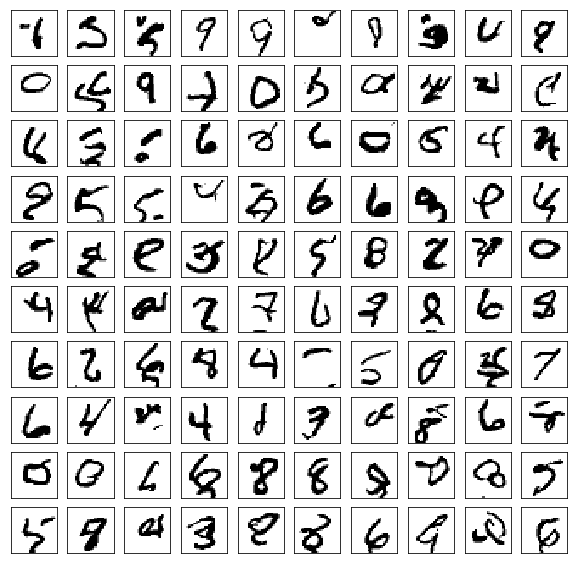

In [15]:
# --------------------------------------------------------------------------------------------------------------
# Generating new images
samples = np.zeros((100, height, width, n_channel), dtype='float32')
for i in range(height):
    for j in range(width):
        logits = pixelcnn(samples)
        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
        next_sample = tf.random.categorical(logits[:, i, j, 0, :], 1)
        samples[:, i, j, 0] = (next_sample.numpy() / (q_levels - 1))[:,0]

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i+1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

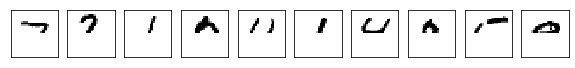

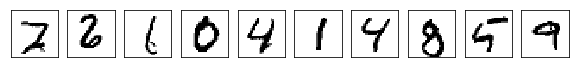

In [16]:
# --------------------------------------------------------------------------------------------------------------
# Filling occluded images
occlude_start_row = 14
num_generated_images = 10
samples = np.copy(x_test_quantised[0:num_generated_images, :, :, :])
samples = samples / (q_levels - 1)
samples[:, occlude_start_row:, :, :] = 0

fig = plt.figure(figsize=(10, 10))

for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

for i in range(occlude_start_row, height):
    for j in range(width):
        logits = pixelcnn(samples)
        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
        next_sample = tf.random.categorical(logits[:, i, j, 0, :], 1)
        samples[:, i, j, 0] = (next_sample.numpy() / (q_levels - 1))[:,0]
    
fig = plt.figure(figsize=(10, 10))

for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

That's looks great, so now let's check with 256 levels.

In [18]:
# --------------------------------------------------------------------------------------------------------------
# Quantise the input data in q levels
q_levels = 256
x_train_quantised = quantise(x_train, q_levels)
x_test_quantised = quantise(x_test, q_levels)

# --------------------------------------------------------------------------------------------------------------
# Creating input stream using tf.data API
batch_size = 128
train_buf = 60000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_quantised / (q_levels - 1),
                                                    x_train_quantised.astype('int32')))
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_quantised / (q_levels - 1),
                                                   x_test_quantised.astype('int32')))
test_dataset = test_dataset.batch(batch_size)

# --------------------------------------------------------------------------------------------------------------
# Create PixelCNN model
inputs = keras.layers.Input(shape=(height, width, n_channel))
x = MaskedConv2D(mask_type='A', filters=128, kernel_size=7, strides=1)(inputs)

for i in range(15):
    x = ResidualBlock(h=64)(x)

x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)
x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=n_channel * q_levels, kernel_size=1, strides=1)(x)  # shape [N,H,W,DC]

pixelcnn = tf.keras.Model(inputs=inputs, outputs=x)
# --------------------------------------------------------------------------------------------------------------
# Prepare optimizer and loss function
lr_decay = 0.99995
learning_rate = 1e-2
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

compute_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# --------------------------------------------------------------------------------------------------------------
@tf.function
def train_step(batch_x, batch_y):
    with tf.GradientTape() as ae_tape:
        logits = pixelcnn(batch_x, training=True)

        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])

        loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    gradients = ae_tape.gradient(loss, pixelcnn.trainable_variables)
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    optimizer.apply_gradients(zip(gradients, pixelcnn.trainable_variables))

    return loss

# --------------------------------------------------------------------------------------------------------------
# Training loop
n_epochs = 150
n_iter = int(np.ceil(x_train_quantised.shape[0] / batch_size))
for epoch in range(n_epochs):
    progbar = Progbar(n_iter)
    print('Epoch {:}/{:}'.format(epoch+1, n_epochs))
        
    for i_iter, (batch_x, batch_y) in enumerate(train_dataset):
        start = time.time()
        optimizer.lr = optimizer.lr * lr_decay
        loss = train_step(batch_x, batch_y)

        progbar.add(1, values=[("loss", loss)])
# --------------------------------------------------------------------------------------------------------------
# Test
test_loss = []
for batch_x, batch_y in test_dataset:
    logits = pixelcnn(batch_x, training=False)
    logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
    logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])

    # Calculate cross-entropy (= negative log-likelihood)
    loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    test_loss.append(loss)
print('nll : {:} nats'.format(np.array(test_loss).mean()))
print('bits/dim : {:}'.format(np.array(test_loss).mean() / (height * width)))


Epoch 1/150
469/469 [==============================] - 79s 169ms/step - loss: 0.9489
Epoch 2/150
469/469 [==============================] - 71s 151ms/step - loss: 0.7708
Epoch 3/150
469/469 [==============================] - 71s 151ms/step - loss: 0.7571
Epoch 4/150
469/469 [==============================] - 71s 151ms/step - loss: 0.7483
Epoch 5/150
469/469 [==============================] - 71s 151ms/step - loss: 0.7411
Epoch 6/150
469/469 [==============================] - 71s 151ms/step - loss: 0.7358
Epoch 7/150
469/469 [==============================] - 71s 151ms/step - loss: 0.7287
Epoch 8/150
469/469 [==============================] - 71s 151ms/step - loss: 0.7217
Epoch 9/150
469/469 [==============================] - 71s 151ms/step - loss: 0.7175
Epoch 10/150
469/469 [==============================] - 71s 151ms/step - loss: 0.7114
Epoch 11/150
469/469 [==============================] - 71s 151ms/step - loss: 0.7103
Epoch 12/150
469/469 [==============================] - 71s 151

469/469 [==============================] - 71s 151ms/step - loss: 0.6128
Epoch 97/150
469/469 [==============================] - 71s 151ms/step - loss: 0.6154
Epoch 98/150
469/469 [==============================] - 71s 151ms/step - loss: 0.6121
Epoch 99/150
469/469 [==============================] - 71s 152ms/step - loss: 0.6118
Epoch 100/150
469/469 [==============================] - 71s 151ms/step - loss: 0.6114
Epoch 101/150
469/469 [==============================] - 71s 151ms/step - loss: 0.6112
Epoch 102/150
469/469 [==============================] - 71s 151ms/step - loss: 0.6124
Epoch 103/150
469/469 [==============================] - 71s 151ms/step - loss: 0.6118
Epoch 104/150
469/469 [==============================] - 71s 152ms/step - loss: 0.6101
Epoch 105/150
469/469 [==============================] - 71s 152ms/step - loss: 0.6111
Epoch 106/150
469/469 [==============================] - 71s 151ms/step - loss: 0.6097
Epoch 107/150
469/469 [==============================] - 71s

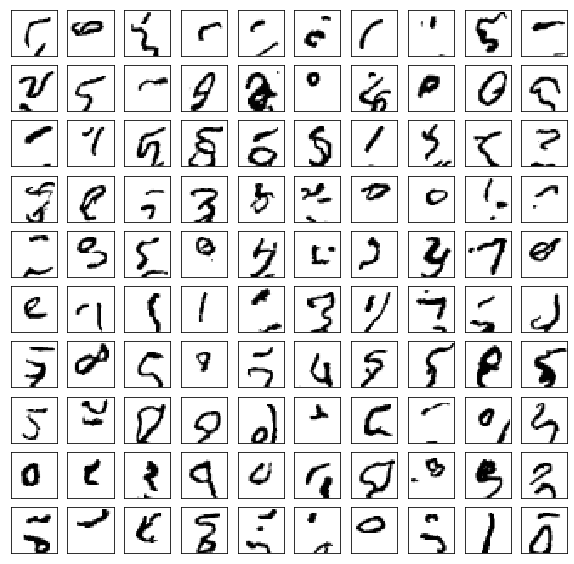

In [19]:
# --------------------------------------------------------------------------------------------------------------
# Generating new images
samples = np.zeros((100, height, width, n_channel), dtype='float32')
for i in range(height):
    for j in range(width):
        logits = pixelcnn(samples)
        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
        next_sample = tf.random.categorical(logits[:, i, j, 0, :], 1)
        samples[:, i, j, 0] = (next_sample.numpy() / (q_levels - 1))[:,0]

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i+1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()


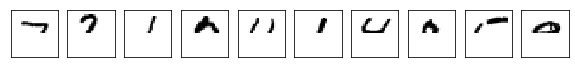

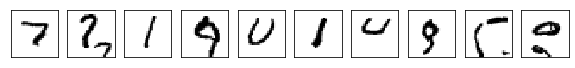

In [20]:
# --------------------------------------------------------------------------------------------------------------
# Filling occluded images
occlude_start_row = 14
num_generated_images = 10
samples = np.copy(x_test_quantised[0:num_generated_images, :, :, :])
samples = samples / (q_levels - 1)
samples[:, occlude_start_row:, :, :] = 0

fig = plt.figure(figsize=(10, 10))

for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

for i in range(occlude_start_row, height):
    for j in range(width):
        logits = pixelcnn(samples)
        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
        next_sample = tf.random.categorical(logits[:, i, j, 0, :], 1)
        samples[:, i, j, 0] = (next_sample.numpy() / (q_levels - 1))[:,0]
    
fig = plt.figure(figsize=(10, 10))

for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()